In [2]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np

In [8]:
# Functions we'll use

def fetch_image_data(image_path: str, 
                     show_image: bool = True) -> np.ndarray:
    """
    Reads an image file from the given path using Pillow, and returns it as a NumPy array.
    Optionally, displays the image using Matplotlib.

    Args:
        image_path (str): Path to the image file.
        show_image (bool): Whether to display the image using Matplotlib. Default is True.

    Returns:
        np.ndarray: A NumPy array representing the image.

    Raises:
        FileNotFoundError: If the specified image file does not exist.
        ValueError: If the specified image file is not a valid image file or could not be read.

    """

    if not os.path.isfile(image_path):
        raise FileNotFoundError(f"{image_path} not found")
    try:
        with Image.open(image_path) as image:
            example_image = plt.imread(image_path)
            if show_image:
                plt.figure()
                plt.imshow(example_image)
                plt.title('Image display of: ' + image_path)
            return example_image
    except Exception as e:
        raise ValueError(f"Could not read {image_path}: {str(e)}")


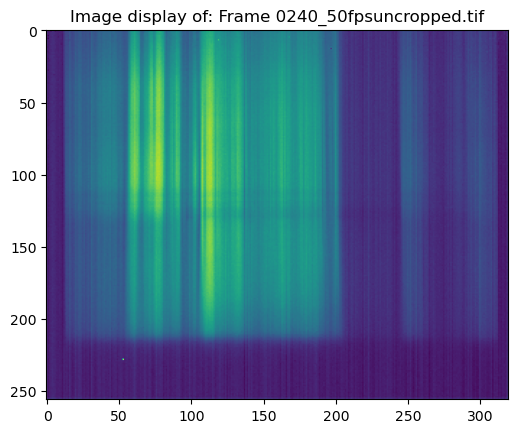

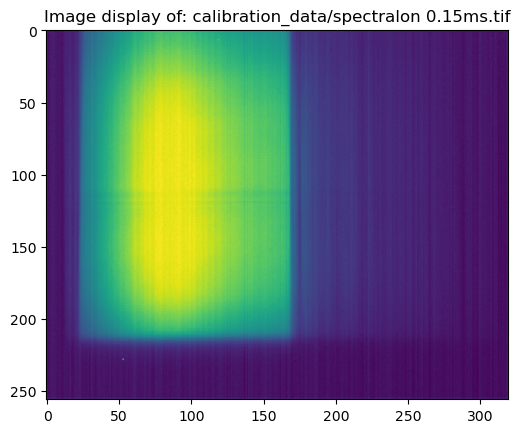

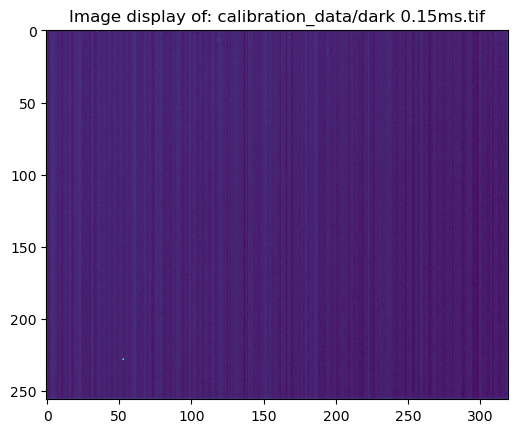

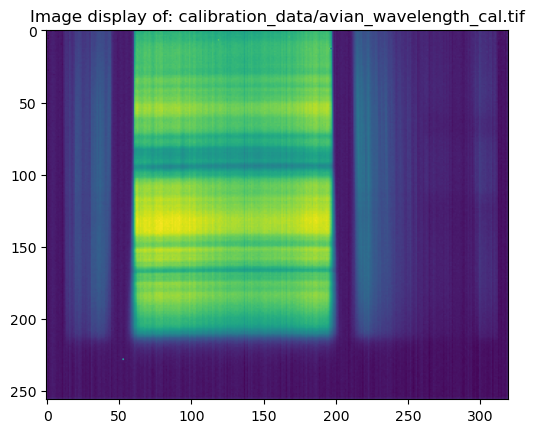

In [7]:
# Collect and display all the image data we're currently interested in 
curr_image = fetch_image_data('Frame 0240_50fpsuncropped.tif')
# curr_image = fetch_image_data('hvc 2197.tif')

white_ref = fetch_image_data('calibration_data/spectralon 0.15ms.tif')
dark_ref = fetch_image_data('calibration_data/dark 0.15ms.tif')
wavelength_ref = fetch_image_data('calibration_data/avian_wavelength_cal.tif')

# Do the same for CSV data
ref_5_df = pd.read_csv('calibration_data/fake_ref_5.csv', header = None)
ref_20_df = pd.read_csv('calibration_data/fake_ref_20.csv', header = None)
ref_80_df = pd.read_csv('calibration_data/fake_ref_80.csv', header = None)
ref_99_df = pd.read_csv('calibration_data/fake_ref_99.csv', header = None)

## Two point linear transformation using white and dark reference signals

(Note that the LaTeX equation rendering is breaking these notebooks, we're going to stick with just normal text here)

r = (s - dr) * (wr - dr)^-1

where r and s are the wavelength specific unitless reflectance and raw signal values for each pixel

dr and wr are the dark and white references

A normalized version of the 99% reflectance target image was used as the white reference signal for all two-point transformations to eliminate the effect of different reference materials.

## More accurate reflectance via regression

Fit least squares regression models to the true reflectance vs. measured average raw signal values for the reflectance targets

Resulting regression coefficients were used to transform the 50% reflectance test set and the sample images
Tested both linear and quadratic transformations to reflectance units

Regression coefficients were obtained separately for each wavelength variable and for each image column
No dark current subtraction performed for regressions

Reflectance images were converted to absorbance via:
A = -log10(r)




In [ ]:
# To get this to work we need to extract ROIs that are the right size and 
# ideally location



/tmp/ipykernel_135/3341866152.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,1,1)


NameError: name 'wavelengths' is not defined

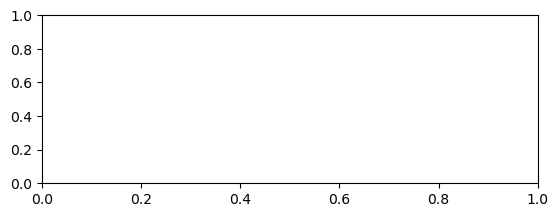

In [9]:
#Two point

curr_image_two_point_called = (curr_image - dark_ref) * (white_ref - dark_ref)**1
plt.imshow(curr_image_two_point_called)

# Plot a random pixel
plt.subplot(2,1,1)
plt.plot(wavelengths, curr_image[:, 100])
plt.legend(['Original'])
# Overlay a calibrated version of the same
plt.subplot(2,1,2)
plt.plot(wavelengths, curr_image_two_point_called[:, 100])
plt.legend(['Two point calibrated'])


NameError: name 'wavelengths' is not defined

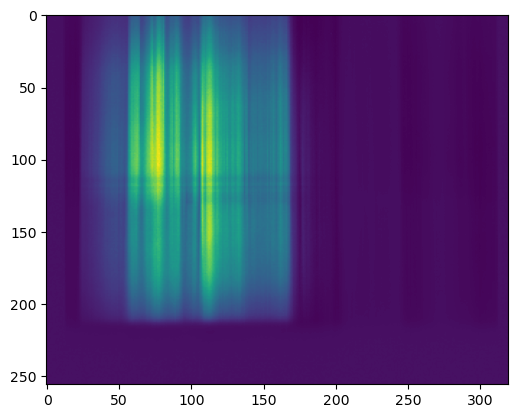

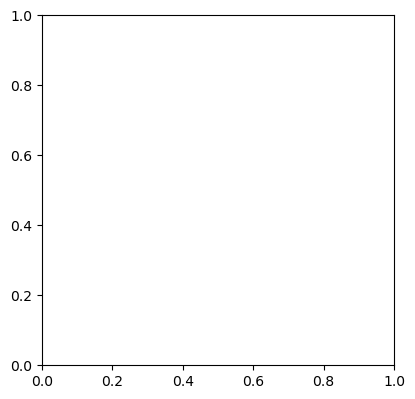

In [10]:
# This is pretty ugly, do we need to normalize everything first?

curr_image_normed = curr_image / curr_image.max()
dark_ref_normed = dark_ref / dark_ref.max()
white_ref_normed = white_ref / white_ref.max()

curr_image_two_point_called = (curr_image_normed - dark_ref_normed) * (white_ref_normed - dark_ref_normed)**1
plt.imshow(curr_image_two_point_called)

plt.figure(figsize=(10,10))

# Plot a random pixel
plt.subplot(2,2,1)
plt.plot(wavelengths, curr_image_normed[:, 100])
plt.legend(['Original'])
# Overlay a calibrated version of the same
plt.subplot(2,2,2)
plt.plot(wavelengths, curr_image_two_point_called[:, 100])
plt.legend(['Global two point calibrated'])

# oh yes we most definitely do, shoudl we be normalizing by column instead?
curr_image_normed = curr_image / curr_image.max(axis=0)
dark_ref_normed = dark_ref / dark_ref.max(axis=0)
white_ref_normed = white_ref / white_ref.max(axis=0)



curr_image_two_point_called = (curr_image_normed - dark_ref_normed) * (white_ref_normed - dark_ref_normed)**1
# plt.imshow(curr_image_two_point_called)

# Plot a random pixel
plt.subplot(2,2,3)
plt.plot(wavelengths, curr_image_normed[:, 150])
plt.legend(['Original'])
# Overlay a calibrated version of the same
plt.subplot(2,2,4)
plt.plot(wavelengths, curr_image_two_point_called[:, 150])
plt.legend(['Columnar two point calibrated'])



## Global regression

### Burger & Geladi: 
```The median spectrum from each of the external standard hypercubes is used to compute a global calibration model one wavelength at a time. The resulting model vectors (individual b0 and b1 of Equation (3) and b0, b1, and b2 of Equation (4) at each wavelength) are then used to transform sample hypercubes from instrument counts (raw data) to reflectance at each wavelength```

### Makela et al:
```This procedure involved fitting least squares regression models to the true reflectance versus measured average raw signal values for the used reflectance targets and then using the regression coefficients for transforming the 50% reflectance test set and the sample images.```

In [11]:



from sklearn.linear_model import LinearRegression
# X = np.array([[1, 1], [1, 2], [2, 2], [2, 3]])
# y = 1 * x_0 + 2 * x_1 + 3
# y = np.dot(X, np.array([1, 2])) + 3


# Select out a single wavelength and get the median
dark_median = np.median(dark_ref[0, :])
ref_5_median = ref_5_df.median(axis = 1)
ref_20_median = ref_20_df.median(axis = 1)
ref_80_median = ref_80_df.median(axis = 1)
ref_99_median = ref_99_df.median(axis = 1)

ref_matrix = np.empty((256, 4))
ref_matrix[:, 0] = ref_5_median
ref_matrix[:, 1] = ref_20_median
ref_matrix[:, 2] = ref_80_median
ref_matrix[:, 3] = ref_99_median

# Median values of each wavelength
y_vals = np.median(curr_image, axis = 1)

# Plot the medians
# plt.plot([ref_5_median, ref_20_median, ref_80_median, ref_99_median])

# LinearRegression?
reg = LinearRegression().fit(ref_matrix, y_vals)
reg.score(ref_matrix, y_vals)

reg.coef_

reg.intercept_

# reg.predict(curr_image)



-25360.8125

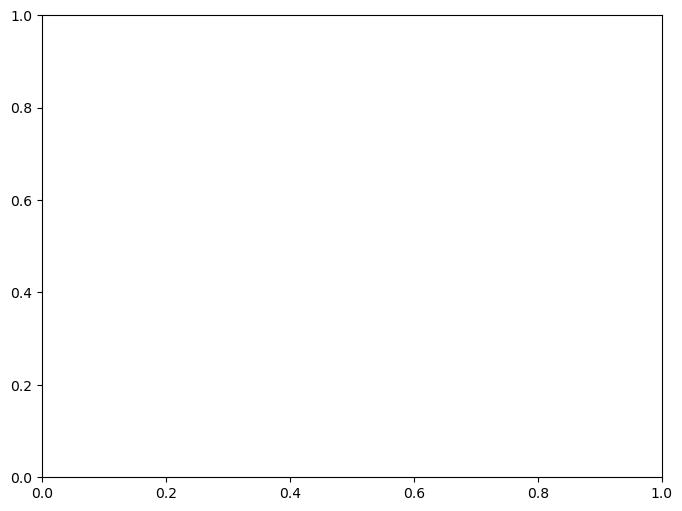

In [12]:
# via statsmodels for another look
import statsmodels.api as sm

X = sm.add_constant(ref_matrix)
model = sm.OLS(y_vals, X)
results = model.fit()
# print(results.summary())

pred_ols = results.get_prediction()
iv_l = pred_ols.summary_frame()["obs_ci_lower"]
iv_u = pred_ols.summary_frame()["obs_ci_upper"]

fig, ax = plt.subplots(figsize=(8, 6))

# ax.plot(X, y_vals, "o", label="data")
# # ax.plot(X, y_true, "b-", label="True")
# ax.plot(X, results.fittedvalues, "r--.", label="OLS")
# ax.plot(x, iv_u, "r--")
# ax.plot(x, iv_l, "r--")
# ax.legend(loc="best")


<Axes: >

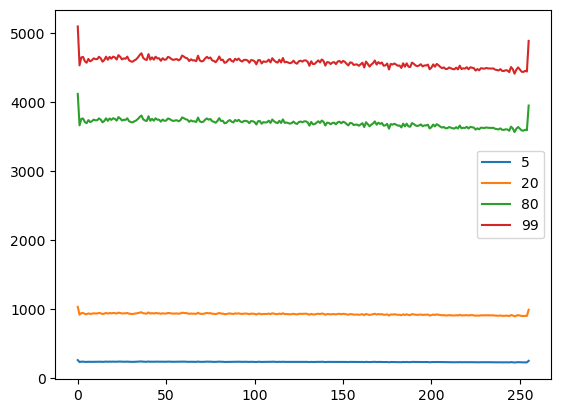

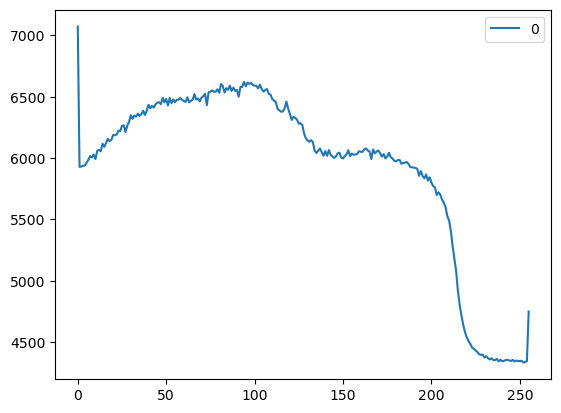

In [13]:
import seaborn as sns

# Let's make a dataframe and go from there

refs_df = pd.DataFrame(ref_matrix, columns = [5, 20, 80, 99])
image_df = pd.DataFrame(y_vals)


refs_df.plot()
image_df.plot()

# sns.lmplot(x="x", y="y", data=anscombe.query("dataset == 'II'"),order=2, ci=None, scatter_kws={"s": 80});

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 6.162e+31
Date:                Thu, 11 May 2023   Prob (F-statistic):           1.62e-32
Time:                        20:07:19   Log-Likelihood:                 124.64
No. Observations:                   4   AIC:                            -245.3
Df Residuals:                       2   BIC:                            -246.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const               0   8.21e-15          0      1.0

/opt/conda/lib/python3.10/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


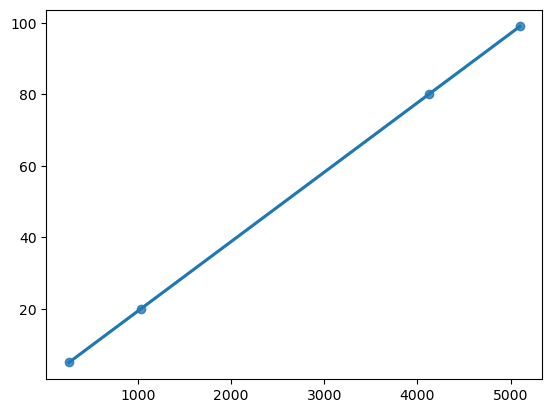

In [14]:
# Okay rethink

# We have our measured data, and then we should have "true" refelectance data. 
# in our case that's assumed to be 5%, 20%, 80%, and 99%. 

x_vals = refs_df.iloc[0,:].index.values
y_from_df = refs_df.iloc[0,:].values

sns.regplot(x = y_from_df, y = x_vals)

X = sm.add_constant(y_from_df)
model = sm.OLS(x_vals, X)
results = model.fit()
print(results.summary())
# model.predict(image_df[0].values)

In [236]:
# results.predict(image_df.iloc[0].values)
# model.predict?
# results.predict?

curr_x = image_df.iloc[0].values
# results.params
curr_y = results.params[1] * curr_x + results.params[0]
print(curr_y)


[137.33009709]


In [21]:

# Fetch the data
x_vals = refs_df.iloc[0,:].index.values
y_from_df = refs_df.iloc[0,:].values

# Fit the model
X = sm.add_constant(y_from_df)
model = sm.OLS(x_vals, X)

# Get the current pixel
curr_x = image_df.iloc[0].values
# Use the parameter to calculate the corrected pixel
curr_y = results.params[1] * curr_x + results.params[0]



(array([7072.5]), array([137.33009709]))

In [27]:
refs_df.iloc[0,:]

5      257.5
20    1030.0
80    4120.0
99    5098.5
Name: 0, dtype: float64